## Tasks
- 다빈도 단어 바 그래프 (예쁘게) → 안지은
- 관련 주제별(대분류) 워드클라우드  → 안지은
- 관련 주제별 설명글 클러스터링 (K-means)
- 토픽 모델링 (Lda)
- 제로샷 모델

In [3]:
#%pip install sklearn
#%pip install pyLDAvis
import pandas as pd
import numpy as np 
import re

# 시각화 라이브러리
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from wordcloud import WordCloud
from collections import Counter
import  numpy as np
from PIL import Image
import plotly 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

font_path1 = r'C:/Windows/Fonts/NanumGothic.ttf' # 기본 matplotlib 폰트
font_path2 = r'C:/Windows/Fonts/bmdohyeon_ttf.ttf' # 배민 도현체 - 워드클라우드에 사용 
font = font_manager.FontProperties(fname = font_path1).get_name()
rc('font',family = font)


# 텍스트 전처리
from konlpy import *
from konlpy.tag import *
kom = Komoran()

# 클러스터링
import sklearn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize


import pyLDAvis
import kmeans_to_pyLDAvis
from kmeans_to_pyLDAvis import kmeans_to_prepared_data

ModuleNotFoundError: No module named 'kmeans_to_pyLDAvis'

In [4]:
import kmeans_to_pyLDAvis

ModuleNotFoundError: No module named 'kmeans_to_pyLDAvis'

In [45]:
ori = pd.read_csv('preprocessed_data.csv')
ori.head()

,제목,발생기간,수집기간:시작일,수집기간:종료일,대주제,소주제,수집건수_웹사이트,수집건수_문서,수집건수_동영상,수집건수_이미지,내용,출처
0,2022년 20대 대통령선거(20대 대선),2022-03-09,2021-09-01,2022-02-26,사회과학,행정학,210,0,0,0,제20대 대통령선거가 2022년 3월 9일 실시된다. 제20대 대통령선거는 18세 ...,>\n중앙선거관리위원회\n(https://www.nec.go.kr/site/vt/e...
1,제16회 도쿄 패럴림픽,2021-08-24,2021-07-05,2021-11-07,예술,"오락,스포츠",261,0,0,0,2021년 8월 24일 9월 5일까지 일본 도쿄에서 열린 제16회 하계 패럴림픽으로...,>\n국제패럴림픽위원회(https://www.paralympic.org/)\n대한장...
2,2021년 대한민국 재보궐선거 (4·7 재보궐선거),2021-07-23,2021-07-05,2021-11-17,사회과학,행정학,271,0,0,0,"2020년 7월 10일 박원순 전 서울시장의 임기 중 사망, 오거돈 전 부산시장 자...",>\n중앙선거관리위원회\n(https://www.nec.go.kr/site/nec/...
3,제32회 2020 도쿄올림픽,2021-07-23,2020-11-03,2021-11-17,예술,"오락,스포츠",511,0,0,0,2021년 7월 23일부터 8월 8일까지 일본 도쿄에서 열린 제32회 하계올림픽으로...,>\n도쿄올림픽 공식홈페이지(https://olympics.com/ko/olympi...
4,문화콘텐츠,2021-01-01,2022-01-27,2022-12-31,예술,"공연예술,매체예술",603,0,0,0,“한류가 아시아와 그 너머 다른 국가들에서도 한국의 문화적 영향력을 확산시켜 한국을...,>\n한국콘텐츠진흥원(https://www.kocca.kr/cop/bbs/view/...


# 0. 명사 분석을 위한 단어 전처리

In [155]:
#  불용어 파일 로드
# 출처 : https://junior-developer.tistory.com/8  + 기타 추가 단어

f = open("koreanStopwords.txt", 'r', encoding = 'utf-8')
lines = f.readlines()
stopwords = []
for line in lines:
    line = line.replace('\n', '')
    stopwords.append(line)
f.close()

# 데이터 프레임 내 모든 레코드의 '내용' 을 합친 후, 명사 추출된 단어 개수 카운트하여 딕셔너리로 리턴해주는 함수
def concat_all_sent(df):
    words = []
    cnt_dict = {}
    for word in df['내용'] : 
        words.append(word)   
    sentence = ' '.join(words)
    new_str = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sentence)
    nouns = kom.nouns(new_str)
    cnt_dict = Counter(nouns)
    return cnt_dict

# 딕셔너리를 데이터 프레임 형태로 바꿔주는 함수
def dict_to_df(dict):
    dict_to_df = pd.DataFrame(columns = ['형태소', '빈도'])
    dict_to_df['형태소'] = dict.keys()
    dict_to_df['빈도'] = dict.values()
    dict_to_df = dict_to_df.sort_values('빈도',ascending = False)
    return dict_to_df

# 데이터 프레임의 데이터를 딕셔너리 형태로 바꿔주는 함수
def df_to_dict(df):
    new_dict = {}
    for i in range(len(df)):
        new_dict[df['형태소'][i]] = df['빈도'][i]
    return new_dict

# 단어별 빈도수 딕셔너리에서 불용어 제거하는 함수
def filter_word(dict):
    df = dict_to_df(dict)
    new_dict = {}
    for i in range(len(df)):
        if (len(df['형태소'][i]) > 1 and df['형태소'][i] not in stopwords) :
            new_dict[df['형태소'][i]] = df['빈도'][i]
    new_df = dict_to_df(new_dict)
    new_df.reset_index(inplace = True , drop = True)
    return new_df

# 최종 : 데이터프레임 넣으면 해당 부분에 대해 불용어 제거하여 명사 카운트해주는 함수
def filtering(df):
    tg_dict = concat_all_sent(df)
    final_df = filter_word(tg_dict)
    return final_df

# 1. 시각화

In [100]:
# 빈도수 30개 그래프 시각화
def vis_cnt(df, title):
    data1 = go.Bar(x=df['형태소'], y=df['빈도'], name ='빈도수')
    data2 = go.Line(x=df['형태소'], y=df['빈도'], name = '추세선')
    layout = go.Layout(title=title)
    fig = go.Figure(data=[data1, data2], layout=layout)
    fig.show()

# 워드클라우드 시각화
def make_wc(dict, title, c_map):
    fig = plt.figure(figsize = (10, 10))
    wordcloud = WordCloud(
    font_path = font_path2, 
    background_color='white',  
    colormap=c_map
    ).generate_from_frequencies(dict)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title,fontsize = 16)
    plt.box(False)
    plt.axis(False)
    plt.show()

In [113]:
subjects = list(ori['대주제'].unique())
subjects

['사회과학', '예술', '자연과학', '기술과학', '역사', '총류', '문학']

## 1-1. 전체 단어 집합 

In [157]:
all_cont = filtering(ori)
all_cont_dict= df_to_dict(all_cont[:300])

### 1-1-1. 상위 30개 단어 빈도수

In [158]:
vis_cnt(all_cont[:30], 'oasis 개별 컬렉션 설명글 단어 집합 출현빈도 상위 30개 단어')

c:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### 1-1-2. 상위 300 개 단어 워드클라우드 

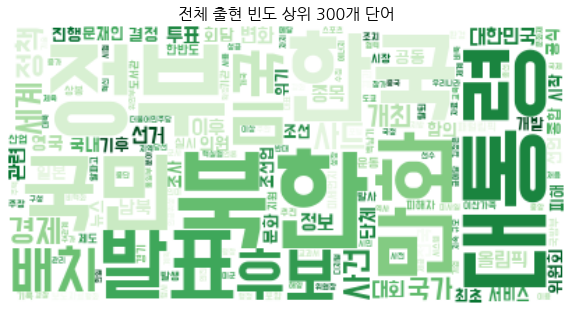

In [159]:
make_wc(all_cont_dict, '전체 출현 빈도 상위 300개 단어', 'Greens')

## 1-2. 주제별 시각화

### 주제별 분포 비율

([<matplotlib.patches.Wedge at 0x1fa67358d90>,
 [Text(-0.11758472681192757, 1.0936973219408395, '사회과학'),
  Text(-0.7495596102084324, -0.8050840892380019, '예술'),
  Text(0.19530866099887825, -1.0825222985873433, '역사'),
  Text(0.74955983634064, -0.8050838787014636, '총류'),
  Text(1.0005952532309026, -0.45695638655323106, '기술과학'),
  Text(1.0748615839135987, -0.23382167441610263, '자연과학'),
  Text(1.09719733692506, -0.0784729497633192, '문학')],
 [Text(-0.06413712371559685, 0.5965621756040942, '53%'),
  Text(-0.40885069647732675, -0.439136775948001, '19%'),
  Text(0.10653199690847903, -0.5904667083203691, '10%'),
  Text(0.40885081982216726, -0.4391366611098892, '8%'),
  Text(0.5457792290350377, -0.2492489381199442, '5%'),
  Text(0.5862881366801447, -0.12753909513605596, '2%'),
  Text(0.5984712746863963, -0.04280342714362865, '2%')])

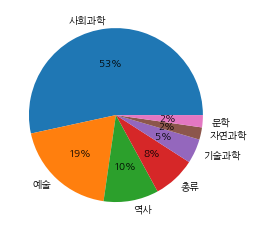

In [236]:
subject_df = pd.DataFrame(columns = ['대주제','count'])
subject_df['대주제']= list(Counter(ori['대주제']).keys())
subject_df['count'] = list(Counter(ori['대주제']).values())
subject_df = subject_df.sort_values(by='count', ascending = False)
plt.pie(subject_df['count'], labels = subject_df['대주제'], autopct = '%0.0f%%')

### 1-2-1. 기술과학

In [116]:
mechanic = ori[ori['대주제'] == '기술과학']
mechanic = filtering(mechanic)
mechanic_dict =  df_to_dict(mechanic[:300])

#### (1) 출현 빈도 상위 30개 단어 빈도수

In [117]:
vis_cnt(mechanic[:30], '기술과학 분야 출현빈도 상위 30개 단어')

c:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#### (2) 출현 빈도 상위 300개 단어 워드클라우드

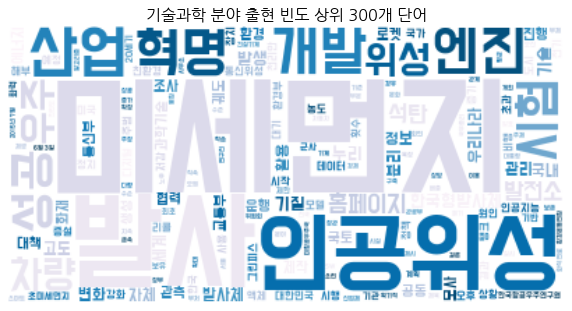

In [120]:
make_wc(mechanic_dict, '기술과학 분야 출현 빈도 상위 300개 단어', 'PuBu')

### 1-2-2. 자연과학

In [121]:
nature = ori[ori['대주제'] == '자연과학']
nature = filtering(nature)
nature_dict =  df_to_dict(nature[:300])

#### (1) 출현 빈도 상위 30개 단어 빈도수

In [122]:
vis_cnt(nature[:30], '자연과학 분야 출현빈도 상위 30개 단어')

c:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#### (2) 출현 빈도 상위 300개 단어 워드클라우드

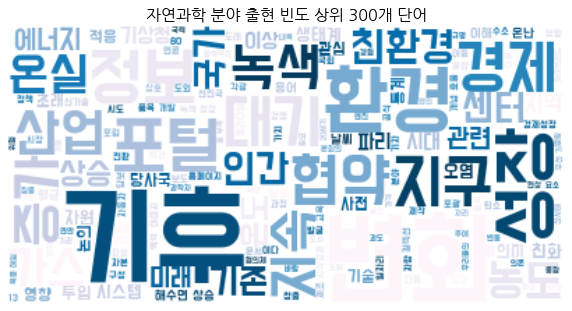

In [123]:
make_wc(nature_dict, '자연과학 분야 출현 빈도 상위 300개 단어', 'PuBu')

### 1-2-3. 사회과학

In [124]:
social = ori[ori['대주제'] == '사회과학']
social = filtering(social)
social_dict =  df_to_dict(social[:300])

#### (1) 출현 빈도 상위 30개 단어 빈도수

In [125]:
vis_cnt(social[:30], '사회과학 분야 출현빈도 상위 30개 단어')

c:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#### (2) 출현 빈도 상위 300개 단어 워드클라우드

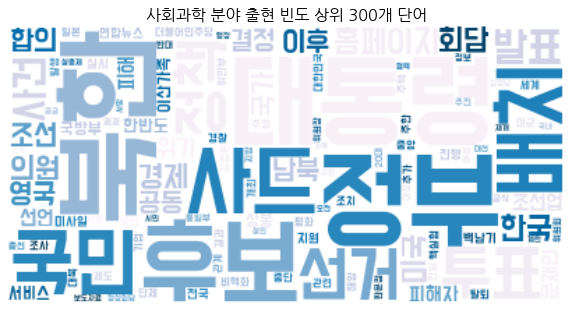

In [139]:
make_wc(social_dict, '사회과학 분야 출현 빈도 상위 300개 단어', 'PuBu')

### 1-2-4. 역사 

In [140]:
history = ori[ori['대주제'] == '역사']
history = filtering(history)
history_dict =  df_to_dict(history[:300])

#### (1) 출현 빈도 상위 30개 단어 빈도수

In [141]:
vis_cnt(history[:30], '역사 분야 출현빈도 상위 30개 단어')

c:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#### (2) 출현 빈도 상위 300개 단어 워드클라우드

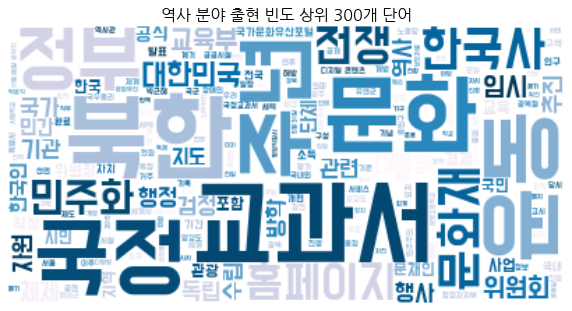

In [142]:
make_wc(history_dict, '역사 분야 출현 빈도 상위 300개 단어', 'PuBu')

### 1-2-5. 문학

In [143]:
literate = ori[ori['대주제'] == '문학']
literate = filtering(literate)
literate_dict =  df_to_dict(literate[:300])

#### (1) 출현 빈도 상위 30개 단어 빈도수

In [145]:
vis_cnt(literate[:30], '문학 분야 출현빈도 상위 30개 단어')

c:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#### (2) 출현 빈도 상위 300개 단어 워드클라우드

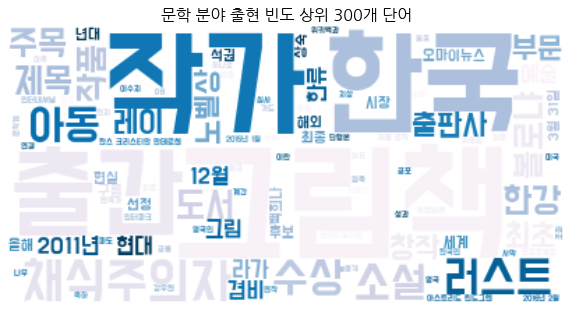

In [146]:
make_wc(literate_dict, '문학 분야 출현 빈도 상위 300개 단어', 'PuBu')

### 1-2-6. 예술

In [147]:
arts = ori[ori['대주제'] == '예술']
arts = filtering(arts)
arts_dict =  df_to_dict(arts[:300])

#### (1) 출현 빈도 상위 30개 단어 빈도수

In [148]:
vis_cnt(arts[:30], '예술 분야 출현빈도 상위 30개 단어')

c:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#### (2) 출현 빈도 상위 300개 단어 워드클라우드

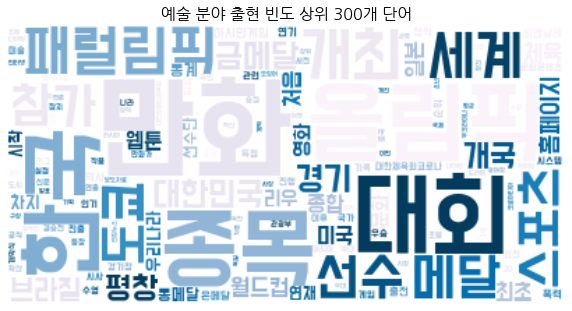

In [151]:
make_wc(arts_dict, '예술 분야 출현 빈도 상위 300개 단어', 'PuBu')

### 1-2-7. 총류

In [152]:
gen = ori[ori['대주제'] == '총류']
gen = filtering(gen)
gen_dict =  df_to_dict(gen[:300])

#### (1) 출현 빈도 상위 30개 단어 빈도수

In [153]:
vis_cnt(gen[:30], '총류 분야 출현빈도 상위 30개 단어')

c:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#### (2) 출현 빈도 상위 300개 단어 워드클라우드

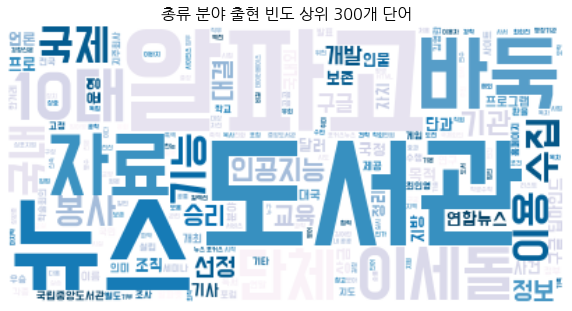

In [154]:
make_wc(gen_dict, '총류 분야 출현 빈도 상위 300개 단어', 'PuBu')

# 2. 머신러닝

## 2-1. 토픽모델링

### 2-2-1. K-means 클러스터링
- 비지도 학습, 데이터간 유사성을 바탕으로 학습
- 참고 코드 출처 : https://wonhwa.tistory.com/28 , https://lovit.github.io/nlp/2018/09/27/pyldavis_kmeans/

#### (0) 데이터 전처리 및 벡터화

In [228]:
# 전처리
def before_vectorize(df):
    contents = []
    for cont in df['내용']:
        tokens = kom.nouns(cont)
        getin_tokens = []
        for w in tokens:
            if w not in stopwords:
                getin_tokens.append(w)
        contents.append(getin_tokens)
    text = [' '.join(contents[i]) for i in range(len(contents))]
    return text

# 문장 벡터화
in_text = before_vectorize(ori)
vectorize = CountVectorizer()
vec = vectorize.fit_transform(in_text)
vec = normalize(vec)

# 문장-단어 매트릭스 데이터프레임
vec_df = pd.DataFrame(vec.toarray(), columns = vectorize.get_feature_names_out())

In [229]:
vec_df

,100년,10대,10월,10일,119,11년,11월,11일,12월,12일,...,훼손,휠체어,휴가,흉기,흐름,흡수,흥행,희생,희화,힐러리
0,0.0,0.0,0.000000,0.088388,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.026968,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.048912,0.000000,0.0,0.0,0.048912,0.0,0.048912,0.048912,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,0.0,0.0,0.000000,0.000000,0.0,0.0,0.065407,0.0,0.032703,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.136717,0.0,0.0,0.0,0.0,0.0
85,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
86,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


#### (1) 1차 클러스터 형성 - 7개(사이트 내에서 제시한 분류)

In [230]:
kmeans = KMeans(n_clusters=7).fit(vec_df)

In [231]:
def make_compare_frame(result):
    compare_sub = pd.DataFrame()
    compare_sub['원_대주제'] = ori['대주제']
    compare_sub['kmeans-결과'] = result.labels_
    compare_sub['count'] = 1
    compare_sub2 = compare_sub.groupby(['kmeans-결과','원_대주제']).sum()
    compare_sub2 = compare_sub2.reset_index()

    sub_code = {'사회과학':0, '예술':1, '자연과학':2, '기술과학':3, '역사':4,'총류':5, '문학':6}
    subcodes = []
    for i in range(len(compare_sub2)):
        subcodes.append(sub_code[compare_sub2['원_대주제'][i]])
    compare_sub2['대주제_코드'] = subcodes
    
    return compare_sub2


In [232]:
comp_df = make_compare_frame(kmeans)
fig = px.scatter(comp_df,
                 x='kmeans-결과',
                 y='대주제_코드',
                 size= 'count',
                 color='원_대주제',)
fig

- 예상 : 오아시스에서 분류된 대로 클러스터링 되었을 것으로 예상
- 결과 : 
    - 3번을 위주로 클러스터링 됨 -> 클러스터 개수의 재선정이 필요함
    - 특히 3번의 경우, 기술과학, 자연과학과 같은 인문학이나 사회과학과는 주제적으로 다소 거리가 있는 주제 분야도 섞여 있으므로, 클러스터를 7개로 설정하는 것은 적합하지 않아 보임. 
- 더 적은 수의 클러스터 개수 설정이 필요해 보임


##### (+) pyLDAvis로 시각화

In [241]:
kmeans.cluster_centers_

array([[ 2.71050543e-20, -3.46944695e-18,  1.25412186e-02, ...,
         4.36029010e-03,  0.00000000e+00,  8.76889403e-03],
       [ 2.71050543e-20, -1.73472348e-18,  0.00000000e+00, ...,
         2.16840434e-19, -1.08420217e-19,  2.16840434e-19],
       [ 2.71050543e-20,  0.00000000e+00,  1.40859042e-02, ...,
         2.16840434e-19,  0.00000000e+00,  2.16840434e-19],
       ...,
       [ 5.42101086e-20,  6.97994945e-02,  1.44739413e-02, ...,
         2.16840434e-19,  0.00000000e+00,  4.33680869e-19],
       [ 7.28711238e-04, -1.73472348e-18,  7.20387585e-03, ...,
         1.79471038e-03, -3.25260652e-19, -4.33680869e-19],
       [ 2.71050543e-20,  0.00000000e+00,  0.00000000e+00, ...,
         2.16840434e-19,  0.00000000e+00,  2.16840434e-19]])

In [243]:
# k-means + pyLDAvis
%pip in in
import pyLDAvis
from kmeans_visualizer import kmeans_to_prepared_data


# clustering labeling
labels = kmeans.labels_
centers = kmeans.cluster_centers_

prepared_data = kmeans_to_prepared_data(
    vec_df, vec, centers, labels,
    embedding_method='tsne'
)
pyLDAvis.display(prepared_data)

ModuleNotFoundError: No module named 'pyLDAvis'

#### (2) 클러스터 개수 찾기
- 클러스터 개수의 재설정을 위해, 두 가지 방법을 통해 보다 객관적으로 클러스터 개수를 선정하고자 함.
- 참고 : https://nicola-ml.tistory.com/66

##### (2)-1. Elbow method

In [233]:
def visualize_elbowmethod(data, param_init='random', param_n_init=30, param_max_iter=600):
    distortions = []
    for i in range(1, 7):
        km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)

    plt.plot(range(1, 7), distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



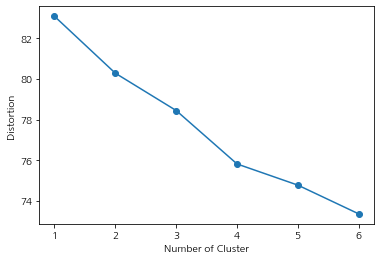

In [234]:
visualize_elbowmethod(vec_df) # 최적 함수 개수 : 4

##### (2)-2. Silhouette Score

#### (3) 2차 클러스터 형성

In [235]:
# elbow method 
kmeans_revised = KMeans(n_clusters=4).fit(vec_df)
comp_df_revised = make_compare_frame(kmeans_revised)
fig = px.scatter(comp_df_revised,
                 x='kmeans-결과',
                 y='대주제_코드',
                 size= 'count',
                 color='원_대주제',)
fig

### 2-2-2. 잠재 디리클레 할당(LDA)

### 2-2-3